# Prepare object detection dataset

## Label images

Use [labelImg](https://github.com/tzutalin/labelImg) to label your images if they are unlabelled. Remember to change to YOLO format. Each image will have an accompanying text file with the class label and bounding box coordinates.

In [1]:
import pandas as pd
import os
import PIL
import numpy as np
from PIL import ImageEnhance, ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches

In [2]:
PATH = "cones"
TRAIN_PATH = os.path.join(PATH, "train")
VAL_PATH = os.path.join(PATH, "val")
trainimgs = [i for i in os.listdir(TRAIN_PATH) if i.endswith("jpg")]
traintxts = [i for i in os.listdir(TRAIN_PATH) if i.endswith("txt")]
valtxts = [i for i in os.listdir(VAL_PATH) if i.endswith("txt")]

In [3]:
trainimgs = sorted([int(x.split('.')[0]) for x in trainimgs])
trainimgs = [str(x) + '.jpg' for x in trainimgs]
traintxts = sorted([int(x.split('.')[0]) for x in traintxts])
traintxts = [str(x) + '.txt' for x in traintxts]

In [4]:
# Check if blank txt files are present
errors = []
for i in traintxts:
    with open(os.path.join(TRAIN_PATH, i), "r") as f:
        first = f.read(1)
        if not first:
            errors.append(i)
errors

[]

In [5]:
errors = []
for i in valtxts:
    with open(os.path.join(VAL_PATH, i), "r") as f:
        first = f.read(1)
        if not first:
            errors.append(i)
errors

[]

In [6]:
categories = ["yellow_big", "yellow_small", "red", "stone"]
categories = {k: v for k,v in enumerate(categories)}
categories

{0: 'yellow_big', 1: 'yellow_small', 2: 'red', 3: 'stone'}

### Visualize images in dataset

In [11]:
def visualiseImgOnly(image):    
    fig = plt.figure()

    #add axes to the image
    ax = fig.add_axes([0, 0, 1, 1])
    # read and plot the image
#     pimage = plt.imread(os.path.join(train_imgs_folder, image))
    plt.imshow(image)

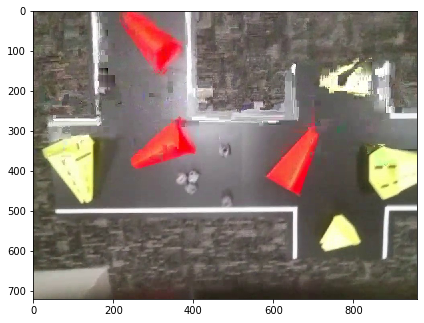

In [12]:
visualiseImgOnly(Image.open(os.path.join(TRAIN_PATH, trainimgs[30])))

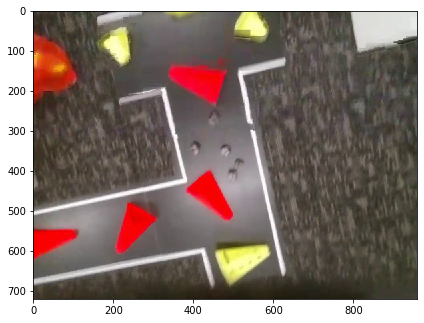

In [13]:
visualiseImgOnly(Image.open(os.path.join(TRAIN_PATH, trainimgs[15])))

## Generate augmentations with PIL and adjust bounding box accordingly

#### Function to visualize images with bounding box

In [7]:
def visualise(image, labels):    
    fig = plt.figure()

    #add axes to the image
    ax = fig.add_axes([0, 0, 1, 1])
    # read and plot the image
#     pimage = plt.imread(os.path.join(train_imgs_folder, image))
    plt.imshow(image)
    # iterating over the image for different objects
    w, h= image.size
    for i in labels:
        i = [float(j) for j in i]
        c, xc, yc, width, height = i
        c = int(c)
        xc = xc * w
        yc = yc* h
        width = w*width
        height = h*height
        
        xmin = xc - width/2
        xmax = xc + width/2
        ymin = yc - height/2
        ymax = yc + height/2
        
        
    # assign different color to different classes of objects
        if c ==  0:
            edgecolor = "red"
            ax.annotate(categories[c], xy=(xmax-40,ymin+20))
        elif c == 2:
            edgecolor = "blue"
            ax.annotate(categories[c], xy=(xmax-40,ymin+20))
        elif c == 3:
            edgecolor = "green"
            ax.annotate(categories[c], xy=(xmax-40,ymin+20))
        elif c == 4:
            edgecolor = "yellow"
            ax.annotate(categories[c], xy=(xmax-40,ymin+20))
        elif c == 5:    
            edgecolor = "purple"
            ax.annotate(categories[c], xy=(xmax-40,ymin+20))

    # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), 
                             width, height, 
                             edgecolor = edgecolor, 
                             facecolor = 'none')
        ax.add_patch(rect)
    plt.show(block=False)

#### Function to generate augmentations and augment the bounding box

In [8]:
'''
Augmentation methods. We need to implement our own augmentation because native support in keras does not change the bounding box 
labels for us as the image is altered. We need to do it ourselves.
'''
# Helper method: Computes the boundary of the image that includes all bboxes
def compute_reasonable_boundary(labels):
    bounds = [ (x-w/2, x+w/2, y-h/2, y+h/2) for _,x,y,w,h in labels]
    xmin = min([bb[0] for bb in bounds])
    xmax = max([bb[1] for bb in bounds])
    ymin = min([bb[2] for bb in bounds])
    ymax = max([bb[3] for bb in bounds])
    return xmin, xmax, ymin, ymax

def aug_horizontal_flip(img, labels):
    flipped_labels = []
    for c,x,y,w,h in labels:
        flipped_labels.append( (c,1-x,y,w,h) )
    return img.transpose(PIL.Image.FLIP_LEFT_RIGHT), np.array(flipped_labels)

# def aug_vertical_flip(img, labels):
#     flipped_labels = []
#     for c,x,y,w,h in labels:
#         flipped_labels.append( (c,x,1-y,w,h) )
#     return img.transpose(PIL.Image.FLIP_TOP_BOTTOM), np.array(flipped_labels)

def aug_crop(img, labels):
    # Compute bounds such that no boxes are cut out
    xmin, xmax, ymin, ymax = compute_reasonable_boundary(labels)
    # Choose crop_xmin from [0, xmin]
    crop_xmin = max( np.random.uniform() * xmin, 0 )
    # Choose crop_xmax from [xmax, 1]
    crop_xmax = min( xmax + (np.random.uniform() * (1-xmax)), 1 )
    # Choose crop_ymin from [0, ymin]
    crop_ymin = max( np.random.uniform() * ymin, 0 )
    # Choose crop_ymax from [ymax, 1]
    crop_ymax = min( ymax + (np.random.uniform() * (1-ymax)), 1 )
    # Compute the "new" width and height of the cropped image
    crop_w = crop_xmax - crop_xmin
    crop_h = crop_ymax - crop_ymin
    cropped_labels = []
    for c,x,y,w,h in labels:
        c_x = (x - crop_xmin) / crop_w
        c_y = (y - crop_ymin) / crop_h
        c_w = w / crop_w
        c_h = h / crop_h
        cropped_labels.append( (c,c_x,c_y,c_w,c_h) )

    W,H = img.size
    # Compute the pixel coordinates and perform the crop
    impix_xmin = int(W * crop_xmin)
    impix_xmax = int(W * crop_xmax)
    impix_ymin = int(H * crop_ymin)
    impix_ymax = int(H * crop_ymax)
    return img.crop( (impix_xmin, impix_ymin, impix_xmax, impix_ymax) ), np.array( cropped_labels )

def aug_translate(img, labels):
    # Compute bounds such that no boxes are cut out
    xmin, xmax, ymin, ymax = compute_reasonable_boundary(labels)
    trans_range_x = [-xmin, 1 - xmax]
    tx = trans_range_x[0] + (np.random.uniform() * (trans_range_x[1] - trans_range_x[0]))
    trans_range_y = [-ymin, 1 - ymax]
    ty = trans_range_y[0] + (np.random.uniform() * (trans_range_y[1] - trans_range_y[0]))

    trans_labels = []
    for c,x,y,w,h in labels:
        trans_labels.append( (c,x+tx,y+ty,w,h) )

    W,H = img.size
    tx_pix = int(W * tx)
    ty_pix = int(H * ty)
    return img.rotate(0, translate=(tx_pix, ty_pix)), np.array( trans_labels )

def aug_colorbalance(img, labels, color_factors=[0.2,2.0]):
    factor = color_factors[0] + np.random.uniform() * (color_factors[1] - color_factors[0])
    enhancer = ImageEnhance.Color(img)
    return enhancer.enhance(factor), labels

def aug_contrast(img, labels, contrast_factors=[0.2,2.0]):
    factor = contrast_factors[0] + np.random.uniform() * (contrast_factors[1] - contrast_factors[0])
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(factor), labels

def aug_brightness(img, labels, brightness_factors=[0.2,2.0]):
    factor = brightness_factors[0] + np.random.uniform() * (brightness_factors[1] - brightness_factors[0])
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor), labels

def aug_sharpness(img, labels, sharpness_factors=[0.2,10.0]):
    factor = sharpness_factors[0] + np.random.uniform() * (sharpness_factors[1] - sharpness_factors[0])
    enhancer = ImageEnhance.Sharpness(img)
    return enhancer.enhance(factor), labels

# Performs no augmentations and returns the original image and bbox. Used for the validation images.
def aug_identity(pil_img, label_arr):
    return np.array(pil_img), label_arr

# This is the default augmentation scheme that we will use for each training image.
def aug_default(img, labels, p={'flip':0, 'crop':1, 'translate':1, 'color':0.5, 'contrast':0.5, 'brightness':0.5, 'sharpness':0.75}):
    if p['color'] > np.random.uniform():
        img, labels = aug_colorbalance(img, labels)
    if p['contrast'] > np.random.uniform():
        img, labels = aug_contrast(img, labels)
    if p['brightness'] > np.random.uniform():
        img, labels = aug_brightness(img, labels)
    if p['sharpness'] > np.random.uniform():
        img, labels = aug_sharpness(img, labels)
  
    if p['flip'] > np.random.uniform():
        img, labels = aug_horizontal_flip(img, labels) # aug_horizontal_flip
    if p['crop'] > np.random.uniform():
        img, labels = aug_crop(img, labels)
    if p['translate'] > np.random.uniform():
        img, labels = aug_translate(img, labels)
    return img, labels

#### Function to generate labels of each bounding box

In [9]:
def generateLabels(filename):
    labels = []
    with open(os.path.join(TRAIN_PATH, filename), "r") as f:
        for i in f:
            x = i.strip().split()
            x = [float(i) for i in x]
            x[0] = int(x[0])
            labels.append(x)
    return np.array(labels)

### Test code on one image

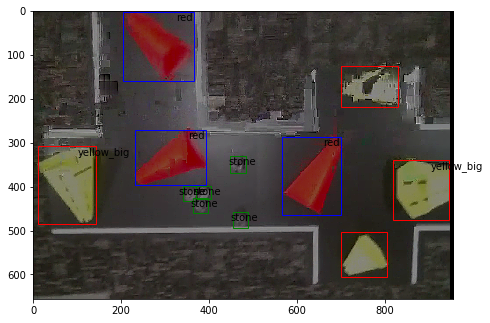

In [10]:
test = Image.open(os.path.join(TRAIN_PATH, trainimgs[30]))
labels = generateLabels(traintxts[30])
img, l = aug_default(test, labels)
visualise(img, l)

### Generate augmentations

In [29]:
AUGMENT_PATH = os.path.join(PATH, "augment")
for i in range(len(trainimgs)): # len(trainimgs)
    im = Image.open(os.path.join(TRAIN_PATH, trainimgs[i]))
    labels = generateLabels(traintxts[i])
    img, l = aug_default(im, labels)
#     visualise(img, l)

    name = trainimgs[i][:-4] + "_au"
    
    if img.mode in ("RGBA", "P"): 
        img = img.convert("RGB")
        
    img.save(AUGMENT_PATH + "/{}".format(name + ".jpg"))
    
    text = []
    for c,x,y,w,h in l.tolist():
        text.append("{} {} {} {} {}\n".format(int(c), round(x, 6), round(y, 6), round(w, 6), round(h, 6)))
       
    with open(AUGMENT_PATH + "/{}".format(name + ".txt"), "w") as f:
        f.writelines(text)

## Check frequency of classes

In [30]:
augtxt = [i for i in os.listdir(AUGMENT_PATH) if i.endswith("txt")]
traintxt = [i for i in os.listdir(TRAIN_PATH) if i.endswith("txt")]

In [32]:
freq = [0,0,0,0]
for i in augtxt:
    with open(os.path.join(AUGMENT_PATH, i), "r") as f:
        for line in f:
            x = line.strip().split(" ")
            x[0] = int(x[0])
            cat = x[0]
            if cat == 0:
                freq[0] += 1 
            elif cat == 1:
                freq[1] += 1
            elif cat == 2:
                freq[2] += 1
            elif cat == 3:
                freq[3] += 1
for i in traintxt:
    with open(os.path.join(TRAIN_PATH, i), "r") as f:
        for line in f:
            x = line.strip().split(" ")
            x[0] = int(x[0])
            cat = x[0]
            if cat == 0:
                freq[0] += 1 
            elif cat == 1:
                freq[1] += 1
            elif cat == 2:
                freq[2] += 1
            elif cat == 3:
                freq[3] += 1

freqd = {k:v for k,v in enumerate(freq)}
freqd

{0: 335, 1: 430, 2: 865, 3: 920}

## Generate txt file for darknet

To train model on custom dataset, we will follow the [darknet tutorial](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects). It requires a txt file containing the paths of the images to be trained.

In [1]:
import os
PATH = "cones"
AUGMENT_PATH = os.path.join(PATH, "augment")
TRAIN_PATH = os.path.join(PATH, "train")

In [21]:
augimg = [i for i in os.listdir(AUGMENT_PATH) if i.endswith("jpg")]
trainimg = [i for i in os.listdir(TRAIN_PATH) if i.endswith("jpg")]
augpath = ["build/darknet/x64/data/obj/"+i for i in augimg]
trainpath = ["build/darknet/x64/data/obj/"+i for i in trainimg]

In [22]:
allpath = augpath+trainpath
allpath

['build/darknet/x64/data/obj/0_au.jpg',
 'build/darknet/x64/data/obj/0_au2.jpg',
 'build/darknet/x64/data/obj/0_au3.jpg',
 'build/darknet/x64/data/obj/0_au4.jpg',
 'build/darknet/x64/data/obj/10_au.jpg',
 'build/darknet/x64/data/obj/10_au2.jpg',
 'build/darknet/x64/data/obj/10_au3.jpg',
 'build/darknet/x64/data/obj/10_au4.jpg',
 'build/darknet/x64/data/obj/12_au.jpg',
 'build/darknet/x64/data/obj/12_au2.jpg',
 'build/darknet/x64/data/obj/12_au3.jpg',
 'build/darknet/x64/data/obj/12_au4.jpg',
 'build/darknet/x64/data/obj/13_au.jpg',
 'build/darknet/x64/data/obj/13_au2.jpg',
 'build/darknet/x64/data/obj/13_au3.jpg',
 'build/darknet/x64/data/obj/13_au4.jpg',
 'build/darknet/x64/data/obj/14_au.jpg',
 'build/darknet/x64/data/obj/14_au2.jpg',
 'build/darknet/x64/data/obj/14_au3.jpg',
 'build/darknet/x64/data/obj/14_au4.jpg',
 'build/darknet/x64/data/obj/15_au.jpg',
 'build/darknet/x64/data/obj/15_au2.jpg',
 'build/darknet/x64/data/obj/15_au3.jpg',
 'build/darknet/x64/data/obj/15_au4.jpg',
 '

In [23]:
with open("cones/train.txt", 'w') as output:
    for row in allpath:
        output.write(str(row) + '\n')

In [17]:
# VAL_PATH = os.path.join(PATH, "stone")
VAL_PATH = PATH + "/stone"
valimg = [i for i in os.listdir(VAL_PATH) if i.endswith("JPG")]
valpath = ["build/darknet/x64/data/obj/"+i for i in valimg]
with open("cones/val.txt", 'w') as output:
    for row in valpath:
        output.write(str(row) + '\n')